<a href="https://colab.research.google.com/github/SunwungLee/tensorflow-study/blob/main/tf_tutorial_2_img_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Tensorflow Tutorials - 1
: 기본 이미지 분류

작성자: 이선웅
작성일: 2021.07.05
'''

'\nTensorflow Tutorials - 1\n: 기본 이미지 분류\n\n작성자: 이선웅\n작성일: 2021.07.05\n'

# 첫 번째 신경망 훈련하기: 기초적인 분류 문제

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.5.0


### 패션 MNIST 데이터셋 임포트하기
10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 패션 MNIST 데이터셋을 사용하겠습니다. 이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 옷 품목을 나타냅니다:

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist # tensorflow.keras.datasets의 데이터중 하나를 가져옴

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() # 해당 데이터 로드

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
print(x_train.shape) # 데이터 shape 확인
print(y_train) # 어떻게 생겼나
class_name = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] # spec에 있는 label들을 정의해줌

(60000, 28, 28)
[9 0 0 ... 3 0 5]


### 데이터 탐색
모델을 훈련하기 전에 데이터셋 구조를 살펴보죠. 다음 코드는 훈련 세트에 60,000개의 이미지가 있다는 것을 보여줍니다. 각 이미지는 28x28 픽셀로 표현됩니다

In [ ]:
print('train set')
print(f'shape: {x_train.shape}') # training dataset의 모양, 6만개, 28x28
print(f'length of labels: {len(y_train)}') # label의 개수

print('test set')
print(f'shape: {x_test.shape}')
print(f'length of labels: {len(y_test)}')

train set
shape: (60000, 28, 28)
length of labels: 60000
test set
shape: (10000, 28, 28)
length of labels: 10000


### 데이터 전처리
네트워크를 훈련하기 전에 데이터를 전처리해야 합니다. 훈련 세트에 있는 첫 번째 이미지를 보면 픽셀 값의 범위가 0~255 사이라는 것을 알 수 있습니다:

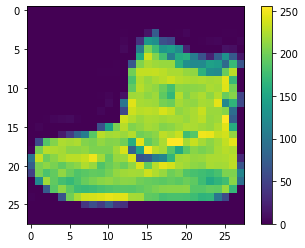

In [ ]:
plt.figure() # figure 하나 만듦
plt.imshow(x_train[0]) # 첫 번째 figure 
plt.colorbar() # 사이드에 colorbar 생성
plt.grid(False) # 격자 없앰 
plt.show() # plot visualisation

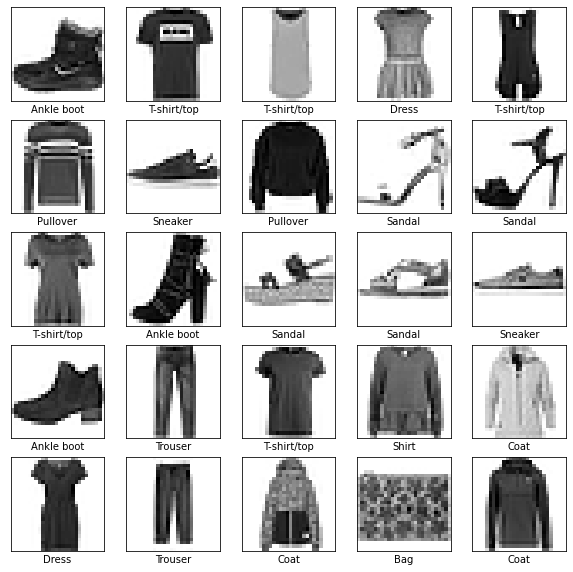

In [ ]:
x_train = x_train/255.0 # 이미지를 0과 1사이의 값으로 맞춤
x_test = x_test/255.0 # 전과 동
plt.figure(figsize=(10,10)) # 총 표시할 figure의 사이즈 표현
for i in range(25): # 25개의 이미지 visualisation
    plt.subplot(5, 5, i+1) # 5x5의 subplot을 만들고 그중에 i번째, (i는 0부터 시작하나, subplot은 1부터시작) 
    plt.xticks([]) # x축 값
    plt.yticks([]) # y축 값, 주석처리하면 값이 나옴.
    plt.grid(False) # 격자 제거
    plt.imshow(x_train[i], cmap=plt.cm.binary) # 이미지를 띄움. colormap은 binary로
    plt.xlabel(class_name[y_train[i]]) # label로부터 class name을 가져와서 xlabel에 대입
plt.show()

### 모델 구성
신경망 모델을 만들려면 모델의 층을 구성한 다음 모델을 컴파일합니다.

####층 설정
신경망의 기본 구성 요소는 층(layer)입니다. 층은 주입된 데이터에서 표현을 추출합니다. 아마도 문제를 해결하는데 더 의미있는 표현이 추출될 것입니다.

대부분 딥러닝은 간단한 층을 연결하여 구성됩니다. `tf.keras.layers.Dense`와 같은 층들의 가중치(parameter)는 훈련하는 동안 학습됩니다.

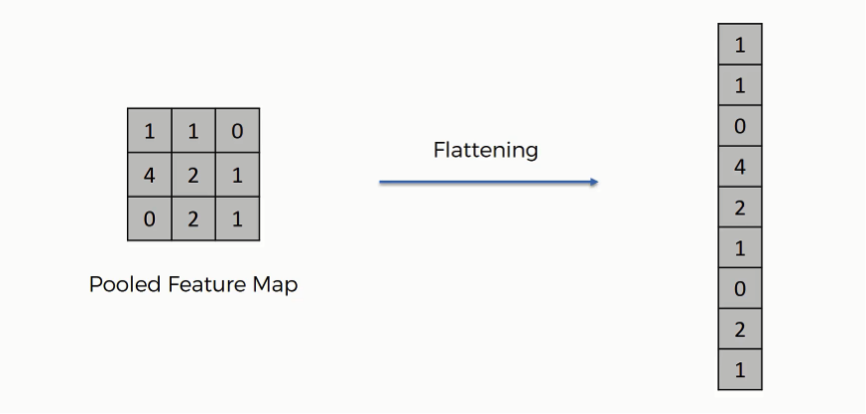

In [ ]:
model = keras.Sequential(
    [
     keras.layers.Flatten(input_shape=(28,28)), # 28x28 이미지를 쭉 핌
     keras.layers.Dense(128, activation='relu'), # fully-connected layer(FC): 이전 계층의 모든 것 뉴런과 연결
     keras.layers.Dense(10, activation='softmax') # softmax를 사용함으로써, 10개의 output으로부터 하나의 값을 도출
    ]
)

### 모델 컴파일
모델을 훈련하기 전에 필요한 몇 가지 설정이 모델 컴파일 단계에서 추가됩니다:

- 손실 함수(Loss function)-훈련 하는 동안 모델의 오차를 측정합니다. 모델의 학습이 올바른 방향으로 향하도록 이 함수를 최소화해야 합니다.
- 옵티마이저(Optimizer)-데이터와 손실 함수를 바탕으로 모델의 업데이트 방법을 결정합니다.
- 지표(Metrics)-훈련 단계와 테스트 단계를 모니터링하기 위해 사용합니다. 다음 예에서는 올바르게 분류된 이미지의 비율인 정확도를 사용합니다.

optimizer에 대한 설명: https://hiddenbeginner.github.io/deeplearning/2019/09/22/optimization_algorithms_in_deep_learning.html

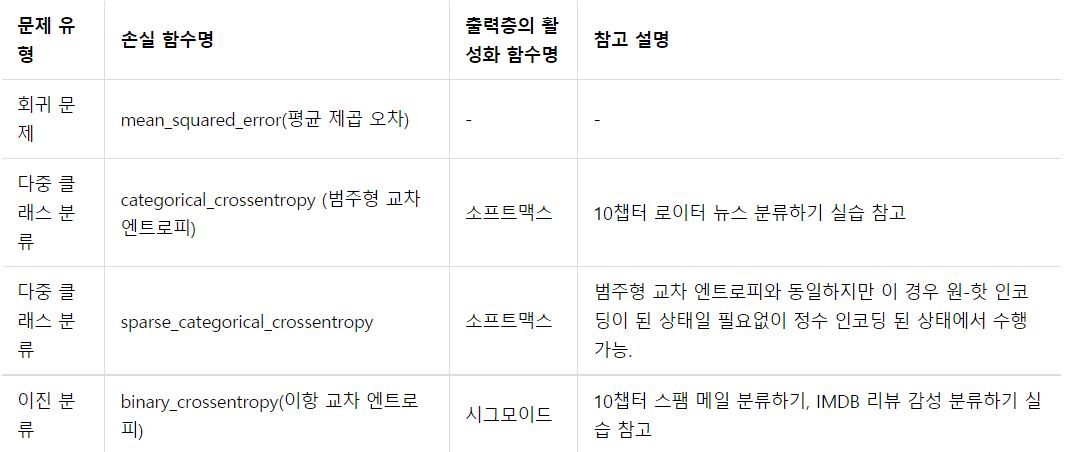

In [ ]:
# https://wikidocs.net/32105
# compile() : 모델을 기계가 이해할 수 있도록 컴파일 합니다. 오차 함수와 최적화 방법, 메트릭 함수를 선택할 수 있습니다.
model.compile(optimizer='adam', # 최적화방법, adaptive momemtum estimation
              loss='sparse_categorical_crossentropy', # 
              metrics=['accuracy']) # 

### 모델 훈련
신경망 모델을 훈련하는 단계는 다음과 같습니다:

1. 훈련 데이터를 모델에 주입합니다-이 예에서는 train_images와 train_labels 배열입니다.
2. 모델이 이미지와 레이블을 매핑하는 방법을 배웁니다.
3. 테스트 세트에 대한 모델의 예측을 만듭니다-이 예에서는 test_images 배열입니다. 이 예측이 test_labels 배열의 레이블과 맞는지 확인합니다.

훈련을 시작하기 위해 `model.fit` 메서드를 호출하면 모델이 훈련 데이터를 학습합니다:

In [ ]:
# fit() : 모델을 학습합니다. 
# 모델이 오차로부터 매개 변수를 업데이트 시키는 과정을 학습, 훈련, 또는 적합(fitting)이라고 하기도 하는데, 
# 모델이 데이터에 적합해가는 과정이기 때문입니다. 
# 그런 의미에서 fit()은 모델의 훈련을 시작한다는 의미를 가지고 있습니다.
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5036 - accuracy: 0.8234
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3738 - accuracy: 0.8650
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3368 - accuracy: 0.8772
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3131 - accuracy: 0.8855
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2953 - accuracy: 0.8901


### 정확도 평가
그다음 테스트 세트에서 모델의 성능을 비교합니다:

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'테스트 정확도: {test_acc}')

313/313 - 0s - loss: 0.3390 - accuracy: 0.8825
테스트 정확도: 0.8824999928474426


###예측 만들기
훈련된 모델을 사용하여 이미지에 대한 예측을 만들 수 있습니다.

In [ ]:
predictions = model.predict(x_test)
print(f'첫 sample의 예측결과: {predictions[0]}')

첫 sample의 예측결과: [4.1873198e-05 3.9340353e-09 2.3226043e-07 4.8710437e-08 3.0913263e-06
 4.8589795e-03 6.1413612e-06 2.4319330e-02 2.0920731e-06 9.7076821e-01]


In [ ]:
print(f'predictions: {np.argmax(predictions[0])}')
print(f'test label: {y_test[0]}')

predictions: 9
test label: 9


10개 클래스에 대한 예측을 모두 그래프로 표현해보자

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_name[predicted_label],
                                         100*np.max(predictions_array),
                                         class_name[true_label]),
               color=color
               )

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color='#777777')
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

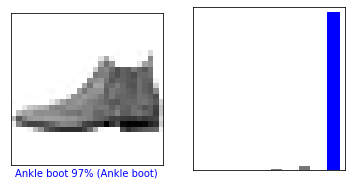

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions, y_test)
plt.show()

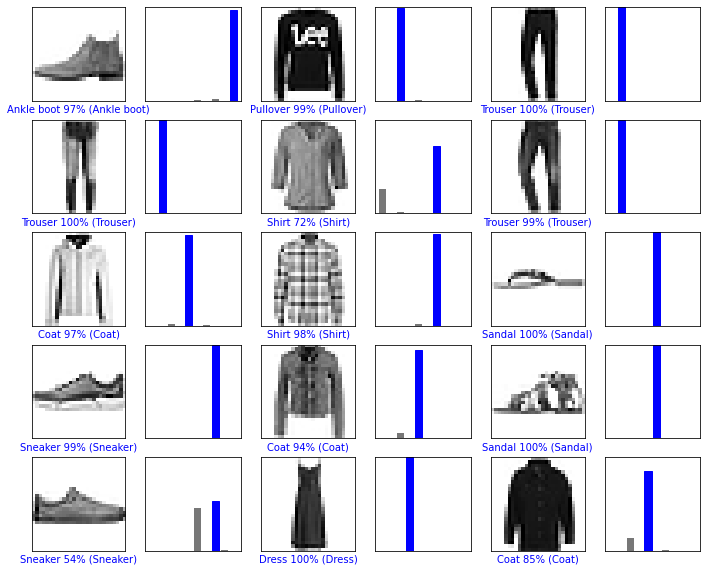

In [ ]:
num_rows = 5
num_cols = 3

num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, y_test, x_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, y_test)
plt.show()

In [ ]:
img = x_test[0]
print(img.shape)

(28, 28)


tf.keras 모델은 한 번에 샘플의 묶음 또는 배치(batch)로 예측을 만드는데 최적화되어 있습니다. 하나의 이미지를 사용할 때에도 2차원 배열로 만들어야 합니다:

In [ ]:
img = x_test[0]
img = (np.expand_dims(img,0))
print(img.shape)
print(type(img))

(1, 28, 28)
<class 'numpy.ndarray'>


In [ ]:
predictions_single = model.predict(img)
print(predictions_single)

[[4.1873282e-05 3.9340353e-09 2.3226043e-07 4.8710529e-08 3.0913236e-06
  4.8589883e-03 6.1413612e-06 2.4319336e-02 2.0920729e-06 9.7076821e-01]]


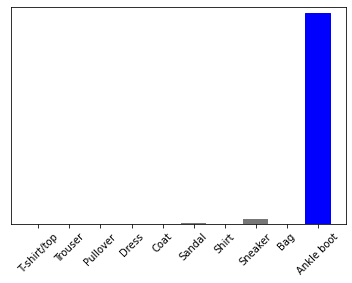

In [ ]:
plot_value_array(0, predictions_single, y_test)
_ = plt.xticks(range(10), class_name, rotation=45)

In [ ]:
np.argmax(predictions_single[0])

9

In [ ]:
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.